# ID5059 Group Project - Gradient Boosting Model

###  This notebook implements a Gradient Boosting model to predict temperature (t2m) from weather data.

### 1. Import Libraries

This section imports the necessary all libraries for the project.

In [4]:
# all import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import os
import time

# modeling
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV

# gpu activation
import xgboost as xgb

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### 2.1 Functions to Load and Preprocess Data

This section defines functions to load the provided datasets for the project. Also it defines convertDateTimeToComponents and prepareData functions, which are used to convert datetime columns to components and prepare the data for further work.

In [5]:
# function to load data from file with sampling
def loadData(fileName, filePath="./", delimiter=",", sample_size=None, random_state=1):
    path = Path(filePath) / fileName

    # exception if file not found
    if not path.is_file():
        raise Exception(f"File not found: {path}")
    
    # load only a sample of the data
    if sample_size is not None:

        # first count total lines to determine skiprows
        total_rows = sum(1 for _ in open(path)) - 1  # subtract 1 for header
        
        # if sample size is greater than or equal to total rows, load the entire dataset
        if sample_size >= total_rows:
            return pd.read_csv(path, sep=delimiter)
        
        # generate random row indices to sample
        np.random.seed(random_state)
        skip_indices = sorted(np.random.choice(
            range(1, total_rows + 1), 
            size=total_rows - sample_size, 
            replace=False
        ))
        
        # always include header (row 0)
        return pd.read_csv(path, sep=delimiter, skiprows=skip_indices)
    else:
        # load entire dataset
        return pd.read_csv(path, sep=delimiter)

# function to convert datetime components
def convertDateTimeToComponents(data, column):
    data["year"] = data[column].dt.year
    data["month"] = data[column].dt.month
    data["day"] = data[column].dt.day
    data["hour"] = data[column].dt.hour
    data["season"] = ((data["month"] % 12 + 3) // 3)  # Winter: 1, Spring: 2, Summer: 3, Fall: 4
    return data

# function to prepare data (drop id, convert time, extract components)
def prepareData(data, keep_valid_time=False):
    # make a copy to avoid modifying the original
    data = data.copy()
    
    # drop ID column
    data.drop(["id"], axis=1, inplace=True)
    
    # convert valid_time to datetime
    data["valid_time"] = pd.to_datetime(data["valid_time"])
    
    # extract datetime components
    data = convertDateTimeToComponents(data, "valid_time")
    
    # optionally keep valid_time (needed for test predictions)
    if not keep_valid_time:
        data.drop(["valid_time"], axis=1, inplace=True)
    
    return data

### 2.2 Load and Preprocess Data

This section uses the functions described above to start working on the datasets. Applies proprocessing to both train and test datasets.

In [10]:
# load full training dataset
filePath = "./"
dataTrain = loadData("train.csv", filePath)  # remove sample_size to load all data

# load full test dataset
dataTest = loadData("test.csv", filePath)  # remove sample_size to load all data

# preprocess both datasets
dataTrain = prepareData(dataTrain)
dataTest = prepareData(dataTest, keep_valid_time=True)  # keep valid_time for predictions

# save valid_time from test data before dropping
test_valid_time = dataTest['valid_time'].copy()
if 'valid_time' in dataTest.columns:
    dataTest.drop(["valid_time"], axis=1, inplace=True)

# display shapes after preprocessing
print(f"Training data shape: {dataTrain.shape}")  
print(f"Test data shape: {dataTest.shape}")   

Training data shape: (13288920, 16)
Test data shape: (13288920, 15)


### 3 Nearby Radius Features + Pressure Gradient

This section defines functions to calculate nearby radius features and pressure gradient. 

These functions enhance the weather dataset by adding spatial context features derived from nearby geographical locations. For each observation point, it calculates statistical aggregations (mean, min, max) of key weather variables from surrounding locations within a specified radius. Additionally, it computes pressure gradients across latitude and longitude to capture atmospheric pressure changes that are crucial for temperature prediction.

In [ ]:
# add features from nearby locations to help with prediction.
# radius: Search radius in degrees (approximately 25 km)
# pressure gradient: Calculate pressure gradient between adjacent points
def add_nearby_features(df, radius=0.25):
    print("Adding nearby spatial features...")
    result_df = df.copy()
    
    # features to create spatial aggregations for - only those available in test data
    key_features = ['sp', 'tp', 'tcc', 'u10', 'v10', 'u100', 'v100', 'ptype']
    
    # create empty columns for spatial features
    for feat in key_features:
        result_df[f'{feat}_nearby_mean'] = np.nan
        result_df[f'{feat}_nearby_min'] = np.nan
        result_df[f'{feat}_nearby_max'] = np.nan
    
    # group by time components that are already in the dataframe
    print("Grouping by time components...")
    time_groups = result_df.groupby(['year', 'month', 'day', 'hour'])
    
    # process time groups
    print(f"Processing {len(time_groups)} time groups for spatial features...")
    group_count = 0
    
    # process each time group
    for time_key, group in time_groups:
        group_count += 1
        if group_count % 10 == 0:
            print(f"Processed {group_count}/{len(time_groups)} time groups...")
        
        # use vectorised operations where possible
        for idx, row in group.iterrows():
            # calculate distances for all points in this time group
            lat_diffs = np.abs(group['latitude'] - row['latitude'])
            lon_diffs = np.abs(group['longitude'] - row['longitude'])
            
            # find nearby points (within radius but not the same point)
            nearby_mask = (lat_diffs <= radius) & (lon_diffs <= radius) & \
                          ((lat_diffs > 0) | (lon_diffs > 0))
            
            nearby = group[nearby_mask]
            
            # skip if no nearby points found
            if len(nearby) == 0:
                continue
                
            # calculate and store statistics for nearby points
            for feat in key_features:
                if feat in nearby.columns:
                    result_df.loc[idx, f'{feat}_nearby_mean'] = nearby[feat].mean()
                    result_df.loc[idx, f'{feat}_nearby_min'] = nearby[feat].min()
                    result_df.loc[idx, f'{feat}_nearby_max'] = nearby[feat].max()
    
    # fill any missing values - points with no neighbors
    for feat in key_features:
        if feat in result_df.columns:
            # fill missing values with the original feature value
            result_df[f'{feat}_nearby_mean'].fillna(result_df[feat], inplace=True)
            result_df[f'{feat}_nearby_min'].fillna(result_df[feat], inplace=True)
            result_df[f'{feat}_nearby_max'].fillna(result_df[feat], inplace=True)
    
    # add regional pressure gradients (useful for weather prediction)
    # create empty gradient columns
    result_df['pressure_lat_gradient'] = np.nan
    result_df['pressure_lon_gradient'] = np.nan
    
    # process latitude gradients for pressure
    for _, group in result_df.groupby(['year', 'month', 'day', 'hour', 'longitude']):
        if len(group) > 1:
            # sort by latitude
            group = group.sort_values('latitude')
            
            # calculate gradients between adjacent points
            lats = group['latitude'].values
            pressures = group['sp'].values  # Surface pressure
            
            # calculate gradients for each adjacent pair
            for i in range(len(group)-1):
                lat_diff = lats[i+1] - lats[i]
                pressure_diff = pressures[i+1] - pressures[i]
                gradient = pressure_diff / lat_diff if lat_diff != 0 else 0
                
                # assign to both points (simplified approach)
                result_df.loc[group.index[i:i+2], 'pressure_lat_gradient'] = gradient
    
    # process longitude gradients for pressure
    for _, group in result_df.groupby(['year', 'month', 'day', 'hour', 'latitude']):
        if len(group) > 1:
            # sort by longitude
            group = group.sort_values('longitude')
            
            # calculate gradients between adjacent points
            lons = group['longitude'].values
            pressures = group['sp'].values  # Surface pressure
            
            # calculate gradients for each adjacent pair
            for i in range(len(group)-1):
                lon_diff = lons[i+1] - lons[i]
                pressure_diff = pressures[i+1] - pressures[i]
                gradient = pressure_diff / lon_diff if lon_diff != 0 else 0
                
                # assign to both points
                result_df.loc[group.index[i:i+2], 'pressure_lon_gradient'] = gradient
    
    # fill missing gradient values with zeros
    result_df['pressure_lat_gradient'].fillna(0, inplace=True)
    result_df['pressure_lon_gradient'].fillna(0, inplace=True)
    
    # count only newly added columns
    added_cols = [col for col in result_df.columns if col not in df.columns]
    print(f"Added {len(added_cols)} new nearby features")
    
    return result_df

# just check if time components are already in dataset
# this should be true because prepareData() adds them
print("\n--- Checking Dataset Time Components ---")
for col in ['year', 'month', 'day', 'hour']:
    print(f"{col} in dataTrain: {col in dataTrain.columns}")
    print(f"{col} in dataTest: {col in dataTest.columns}")

# apply nearby features to already processed datasets
print("\n--- Adding Nearby Features to Datasets ---")
print("Adding nearby features to training data...")
dataTrain_with_features = add_nearby_features(dataTrain)

print("Adding nearby features to test data...")
dataTest_with_features = add_nearby_features(dataTest)

# define attributes based on enhanced datasets
one_hot_attributes = ["year", "month", "day", "hour", "ptype", "season"]
numerical_attributes = [col for col in dataTrain_with_features.columns 
                       if col not in one_hot_attributes + ['t2m', 'id']]

# Print dataset information
print("\n--- Dataset Information ---")
print(f"Training data with features shape: {dataTrain_with_features.shape}")
print(f"Test data with features shape: {dataTest_with_features.shape}")
print(f"\nTotal features: {len(numerical_attributes) + len(one_hot_attributes)}")
print(f"Numerical features: {len(numerical_attributes)}")
print(f"Categorical features: {len(one_hot_attributes)}")

# Save the processed datasets with nearby features
print("\n--- Saving Processed Datasets ---")
os.makedirs("./processed_datasets", exist_ok=True)
dataTrain_with_features.to_pickle("./processed_datasets/train_with_features.pkl")
dataTest_with_features.to_pickle("./processed_datasets/test_with_features.pkl")
print("All datasets processed and saved successfully.")


--- Checking Dataset Time Components ---
year in dataTrain: True
year in dataTest: True
month in dataTrain: True
month in dataTest: True
day in dataTrain: True
day in dataTest: True
hour in dataTrain: True
hour in dataTest: True

--- Adding Nearby Features to Datasets ---
Adding nearby features to training data...
Adding nearby spatial features...
Grouping by time components...
Processing 8760 time groups for spatial features...
Processed 10/8760 time groups...
Processed 20/8760 time groups...
Processed 30/8760 time groups...
Processed 40/8760 time groups...
Processed 50/8760 time groups...
Processed 60/8760 time groups...
Processed 70/8760 time groups...
Processed 80/8760 time groups...
Processed 90/8760 time groups...
Processed 100/8760 time groups...
Processed 110/8760 time groups...
Processed 120/8760 time groups...
Processed 130/8760 time groups...
Processed 140/8760 time groups...
Processed 150/8760 time groups...
Processed 160/8760 time groups...
Processed 170/8760 time groups.

C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_21416\2551963435.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df[f'{feat}_nearby_mean'].fillna(result_df[feat], inplace=True)
C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_21416\2551963435.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

Added 26 new nearby features
Adding nearby features to test data...
Adding nearby spatial features...
Grouping by time components...
Processing 8760 time groups for spatial features...
Processed 10/8760 time groups...
Processed 20/8760 time groups...
Processed 30/8760 time groups...
Processed 40/8760 time groups...
Processed 50/8760 time groups...
Processed 60/8760 time groups...
Processed 70/8760 time groups...
Processed 80/8760 time groups...
Processed 90/8760 time groups...
Processed 100/8760 time groups...
Processed 110/8760 time groups...
Processed 120/8760 time groups...
Processed 130/8760 time groups...
Processed 140/8760 time groups...
Processed 150/8760 time groups...
Processed 160/8760 time groups...
Processed 170/8760 time groups...
Processed 180/8760 time groups...
Processed 190/8760 time groups...
Processed 200/8760 time groups...
Processed 210/8760 time groups...
Processed 220/8760 time groups...
Processed 230/8760 time groups...
Processed 240/8760 time groups...
Processe

C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_21416\2551963435.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df[f'{feat}_nearby_mean'].fillna(result_df[feat], inplace=True)
C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_21416\2551963435.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

Added 26 new nearby features

--- Dataset Information ---
Training data with features shape: (13288920, 42)
Test data with features shape: (13288920, 41)

Total features: 41
Numerical features: 35
Categorical features: 6

--- Saving Processed Datasets ---
All datasets processed and saved successfully.


### 4.1  Final Preparation for Model Training

This section implements creats a smaller sample dataset (10%) for hyperparameter tuning and a full dataset for final model training. 

It establishes comprehensive preprocessing pipelines that handle both categorical features (with one-hot encoding) and numerical features (with imputation and scaling), ensuring data is properly formatted for machine learning algorithms. Additionally, it extracts a specific geographical test subset (latitude 56.25, longitude -2.75) as required by the assignment for final predictions.

In [11]:
print("\n--- Preparing Data for Model Training ---")

print("\n--- Loading or Accessing Processed Datasets ---")

# Try to access dataTrain_with_features from memory first
try:
    # Check if dataTrain_with_features is already defined
    # This will raise NameError if it's not defined
    dataTrain_with_features
    print("Found dataTrain_with_features in memory, using existing data")
except (NameError, Exception) as e:
    # If not found or other error, load from pickle
    print(f"Could not access dataTrain_with_features in memory: {str(e)}")
    print("Loading from saved pickle file instead...")
    try:
        dataTrain_with_features = pd.read_pickle("./processed_datasets/train_with_features.pkl")
        print("Successfully loaded dataTrain_with_features from pickle file")
    except Exception as load_error:
        print(f"Error loading dataTrain_with_features from pickle: {str(load_error)}")
        raise

# Similarly for test data
try:
    # Check if dataTest_with_features is already defined
    dataTest_with_features
    print("Found dataTest_with_features in memory, using existing data")
except (NameError, Exception) as e:
    # If not found or other error, load from pickle
    print(f"Could not access dataTest_with_features in memory: {str(e)}")
    print("Loading from saved pickle file instead...")
    try:
        dataTest_with_features = pd.read_pickle("./processed_datasets/test_with_features.pkl")
        print("Successfully loaded dataTest_with_features from pickle file")
    except Exception as load_error:
        print(f"Error loading dataTest_with_features from pickle: {str(load_error)}")
        raise

# Print dataset information to confirm
print("\n--- Dataset Information ---")
print(f"Training data with features shape: {dataTrain_with_features.shape}")
print(f"Test data with features shape: {dataTest_with_features.shape}")

# create a 10% sample for hyperparameter tuning
dataTrain_sample = dataTrain_with_features.sample(frac=0.1, random_state=RANDOM_SEED)
print(f"Created 10% sample for hyperparameter tuning: {dataTrain_sample.shape}")

# prepare X and y for the sample training data (for hyperparameter tuning)
X_train_sample = dataTrain_sample.drop("t2m", axis=1)
y_train_sample = dataTrain_sample["t2m"]

# split sample training data into training and validation sets
X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(
    X_train_sample, y_train_sample, test_size=0.2, random_state=RANDOM_SEED
)
print(f"Sample training set shape: {X_train_sample.shape}")
print(f"Sample validation set shape: {X_val_sample.shape}")

# prepare full dataset for final training
X_train_full = dataTrain_with_features.drop("t2m", axis=1)
y_train_full = dataTrain_with_features["t2m"]

# split full training data into training and validation sets
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_SEED
)
print(f"Full training set shape: {X_train_full.shape}")
print(f"Full validation set shape: {X_val_full.shape}")

# make sure one_hot_attributes and numerical_attributes are comprehensive
# update the lists to include all columns from the datasets with nearby features
print("\n--- Verifying Feature Categories ---")
all_columns = set(X_train_full.columns)
one_hot_attributes = ["year", "month", "day", "hour", "ptype", "season"]
numerical_attributes = [col for col in all_columns if col not in one_hot_attributes]

# print overview of features
print(f"Total features: {len(one_hot_attributes) + len(numerical_attributes)}")
print(f"Categorical features: {len(one_hot_attributes)}")
print(f"Numerical features: {len(numerical_attributes)}")

# create preprocessing pipelines
onehot_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# combine into column transformer
preprocessor = ColumnTransformer(transformers=[
    ("cat-onehot", onehot_pipeline, one_hot_attributes),
    ("numerical", numerical_pipeline, numerical_attributes)
])

# extract test subset for predictions (coordinates from the assignment)
print("\n--- Extracting Test Subset for Predictions ---")
test_subset = dataTest_with_features[(dataTest_with_features['latitude'] == 56.25) & 
                             (dataTest_with_features['longitude'] == -2.75)]

# handle valid_time for test subset
if 'valid_time' in test_subset.columns:
    test_valid_time = test_subset['valid_time'].copy()
    print("Found valid_time in test subset, saving for predictions")
else:
    # try to restore it from saved test_valid_time if available
    print("No valid_time in test subset, trying to recover from saved variable")
    
    if 'test_valid_time' in globals():
        # find matching indices between test_subset and original test data
        test_indices = test_subset.index
        test_valid_time = test_valid_time.loc[test_indices] if test_valid_time is not None else None
    else:
        print("WARNING: Could not recover valid_time for predictions")
        test_valid_time = None

# print test subset shape and valid time entries
print(f"Test subset shape for predictions: {test_subset.shape}")
print(f"Valid time entries for predictions: {len(test_valid_time) if test_valid_time is not None else 'None'}")

# now ready to proceed with fine-tuning
print("Preprocessing complete. Ready for fine-tuning.")


--- Preparing Data for Model Training ---

--- Loading or Accessing Processed Datasets ---
Could not access dataTrain_with_features in memory: name 'dataTrain_with_features' is not defined
Loading from saved pickle file instead...
Successfully loaded dataTrain_with_features from pickle file
Could not access dataTest_with_features in memory: name 'dataTest_with_features' is not defined
Loading from saved pickle file instead...
Successfully loaded dataTest_with_features from pickle file

--- Dataset Information ---
Training data with features shape: (13288920, 42)
Test data with features shape: (13288920, 41)
Created 10% sample for hyperparameter tuning: (1328892, 42)
Sample training set shape: (1063113, 41)
Sample validation set shape: (265779, 41)
Full training set shape: (10631136, 41)
Full validation set shape: (2657784, 41)

--- Verifying Feature Categories ---
Total features: 41
Categorical features: 6
Numerical features: 35

--- Extracting Test Subset for Predictions ---
No valid

### 4.2 Confirmation of Datasets

This is a small additional step to confirm that the gained train and validation datasets within the file are the same as the one used for other models training

In [ ]:
# load ERA5 data files
print("\n--- Loading ERA5 Data Files ---")
era5_train = pd.read_csv("./ERA5 DATA/era5_train_prepared_with_no_nearby.csv")
era5_val = pd.read_csv("./ERA5 DATA/era5_val_prepared_with_no_nearby.csv")

# print heads of ERA5 datasets
print("\n--- ERA5 Training Data Head ---")
print(era5_train.head())
print("\n--- ERA5 Validation Data Head ---")
print(era5_val.head())

# compare dataset dimensions and content for consistency
print("\n--- Comprehensive Train Dataset Comparison ---")

# compare row counts
print(f"ERA5 train row count: {len(era5_train)}")
print(f"Full train row count: {len(X_train_full)}")
print(f"Row count match: {len(era5_train) == len(X_train_full)}")

# compare column sets
common_cols = list(set(era5_train.columns) & set(X_train_full.columns))
print(f"Number of common columns: {len(common_cols)}")
print(f"ERA5 train unique columns: {set(era5_train.columns) - set(X_train_full.columns)}")
print(f"Full train unique columns: {set(X_train_full.columns) - set(era5_train.columns)}")

# generate 10 random indices to compare
import random
random.seed(42)  # for reproducibility
if len(era5_train) == len(X_train_full):
    random_indices = random.sample(range(len(era5_train)), 10)
    print(f"\nComparing values at 10 random indices: {random_indices}")

    # select columns to compare (using several common columns)
    columns_to_check = ['latitude', 'longitude', 'sp', 'tcc', 'u10', 'v10', 'hour', 'month']
    columns_to_check = [col for col in columns_to_check if col in common_cols]
    
    # compare values at random indices across selected columns
    for col in columns_to_check:
        era5_values = [era5_train.iloc[idx][col] for idx in random_indices]
        full_values = [X_train_full.iloc[idx][col] for idx in random_indices]
        
        print(f"\nColumn: {col}")
        print(f"ERA5 values: {era5_values}")
        print(f"Full values: {full_values}")
        print(f"Match: {all(era5_values[i] == full_values[i] for i in range(len(era5_values)))}")
    
    # overall match status
    all_match = True
    for col in columns_to_check:
        era5_values = [era5_train.iloc[idx][col] for idx in random_indices]
        full_values = [X_train_full.iloc[idx][col] for idx in random_indices]
        if not all(era5_values[i] == full_values[i] for i in range(len(era5_values))):
            all_match = False
            break
    
    print(f"\nOVERALL MATCH ACROSS ALL CHECKED COLUMNS AND INDICES: {all_match}")
else:
    print("Cannot compare random samples - datasets have different row counts")

# compare validation dataset dimensions and content for consistency
print("\n--- Comprehensive Validation Dataset Comparison ---")

# compare row counts
print(f"ERA5 validation row count: {len(era5_val)}")
print(f"Full validation row count: {len(X_val_full)}")
print(f"Row count match: {len(era5_val) == len(X_val_full)}")

# compare column sets
common_cols_val = list(set(era5_val.columns) & set(X_val_full.columns))
print(f"Number of common columns: {len(common_cols_val)}")
print(f"ERA5 validation unique columns: {set(era5_val.columns) - set(X_val_full.columns)}")
print(f"Full validation unique columns: {set(X_val_full.columns) - set(era5_val.columns)}")

# generate 10 random indices to compare
import random
random.seed(42)  # for reproducibility
if len(era5_val) == len(X_val_full):
    random_indices_val = random.sample(range(len(era5_val)), 10)
    print(f"\nComparing values at 10 random indices: {random_indices_val}")

    # select columns to compare (using several common columns)
    columns_to_check_val = ['latitude', 'longitude', 'sp', 'tcc', 'u10', 'v10', 'hour', 'month']
    columns_to_check_val = [col for col in columns_to_check_val if col in common_cols_val]
    
    # compare values at random indices across selected columns
    for col in columns_to_check_val:
        era5_val_values = [era5_val.iloc[idx][col] for idx in random_indices_val]
        full_val_values = [X_val_full.iloc[idx][col] for idx in random_indices_val]
        
        print(f"\nColumn: {col}")
        print(f"ERA5 validation values: {era5_val_values}")
        print(f"Full validation values: {full_val_values}")
        print(f"Match: {all(era5_val_values[i] == full_val_values[i] for i in range(len(era5_val_values)))}")
    
    # overall match status
    all_match_val = True
    for col in columns_to_check_val:
        era5_val_values = [era5_val.iloc[idx][col] for idx in random_indices_val]
        full_val_values = [X_val_full.iloc[idx][col] for idx in random_indices_val]
        if not all(era5_val_values[i] == full_val_values[i] for i in range(len(era5_val_values))):
            all_match_val = False
            break
    
    print(f"\nOVERALL MATCH ACROSS ALL CHECKED VALIDATION COLUMNS AND INDICES: {all_match_val}")
else:
    print("Cannot compare random samples - validation datasets have different row counts")


--- Loading ERA5 Data Files ---

--- ERA5 Training Data Head ---
   latitude  longitude        tp       u10       v10         sp      u100  \
0     56.00      -0.75  0.000000  2.117569  8.345276  101296.94  3.671143   
1     58.75      -5.75  0.000913  5.980820  9.166794  100456.50  8.365173   
2     52.50       1.75  0.000000 -1.023087  3.779327  102173.44 -1.325638   
3     52.00       1.25  0.000000  5.188187  1.900284  101178.25  7.420486   
4     56.75      -6.75  0.000097  6.590653 -6.228958  100491.25  7.399139   

        v100       tcc  ptype        t2m  year  month  day  hour  season  
0  10.726196  0.398621    0.0  290.68433  2018      7   31    17       3  
1  11.827179  1.000000    1.0  287.38440  2018      8   21    20       3  
2   5.412933  0.307495    0.0  278.67260  2018      2   17    10       1  
3   2.424911  1.000000    0.0  286.73853  2018      6   17     4       3  
4  -6.996277  0.369110    1.0  280.39430  2018      2    3     6       1  

--- ERA5 Validation 

### 5. Hyperparameter Tuning

This section performs hyperparameter optimisation for a Gradient Boosting Regressor using RandomizedSearchCV on a 10% sample of the training data to reduce computational cost.

It systematically explores various combinations of model parameters (such as tree depth, learning rate, and loss functions) through 3-fold cross-validation with 20 iterations to identify the configuration that minimises root mean squared error. After finding the optimal parameters, it evaluates the tuned model on a validation set to verify performance before saving the best parameters for the final model.

In [ ]:
print("\n--- Hyperparameter Tuning Using 10% Sample ---")
tuning_start_time = time.time()

# define parameter distributions for RandomizedSearchCV
param_distributions = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
    'model__max_depth': [3, 4, 5, 6, 7],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf': [1, 2, 3],
    'model__subsample': [0.75, 0.8, 0.85, 0.9],
    'model__max_features': [0.7, 0.8, 0.9],
    'model__loss': ['huber', 'squared_error'],
    'model__alpha': [0.8, 0.9, 0.95]  # for huber loss
}

# create the initial pipeline with default values
gb_pipeline_for_search = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=RANDOM_SEED))
])

# set up RandomizedSearchCV
print("Setting up hyperparameter search...")
n_iter = 20  # number of parameter settings sampled
gb_random_search = RandomizedSearchCV(
    estimator=gb_pipeline_for_search,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=3,  # number of cross-validation folds
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # use all available cores
    verbose=1,
    random_state=RANDOM_SEED
)

# fit RandomizedSearchCV on the 10% sample
print(f"Performing randomized search with {n_iter} iterations on 10% sample...")
gb_random_search.fit(X_train_sample, y_train_sample)

# print the best parameters found
print("Best parameters found:")
for param, value in gb_random_search.best_params_.items():
    print(f"{param}: {value}")

# print the best score on the sample
print(f"Best RMSE on sample: {-gb_random_search.best_score_:.4f}")

# evaluate the best model on the sample validation set
best_model_sample = gb_random_search.best_estimator_
val_predictions_sample = best_model_sample.predict(X_val_sample)
val_rmse_sample = np.sqrt(mean_squared_error(y_val_sample, val_predictions_sample))
print(f"Sample validation RMSE with best parameters: {val_rmse_sample:.4f}")

# extract the best parameters for our final model
best_params = {k.replace('model__', ''): v for k, v in gb_random_search.best_params_.items()}
print(f"Best parameters for final model: {best_params}")

# save the time taken for hyperparameter tuning
tuning_time = time.time() - tuning_start_time
print(f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")


--- Hyperparameter Tuning Using 10% Sample ---
Setting up hyperparameter search...
Performing randomized search with 20 iterations on 10% sample...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
model__subsample: 0.85
model__n_estimators: 300
model__min_samples_split: 4
model__min_samples_leaf: 2
model__max_features: 0.9
model__max_depth: 7
model__loss: huber
model__learning_rate: 0.1
model__alpha: 0.95
Best RMSE on sample: 1.2588
Sample validation RMSE with best parameters: 1.2604
Best parameters for final model: {'subsample': 0.85, 'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.9, 'max_depth': 7, 'loss': 'huber', 'learning_rate': 0.1, 'alpha': 0.95}
Hyperparameter tuning completed in 41159.68 seconds


### 6.1 Model Training

This section trains the Gradient Boosting model using the previously optimised hyperparameters on the full dataset. After evaluation on the validation set, it generates predictions for the required test subset and saves both the predictions and the trained model for future use.

In [ ]:
print("\n--- Training Final Model on Full Dataset ---")
training_start_time = time.time()

# rename variables to mark the next step
X_train = X_train_full
y_train = y_train_full
X_val = X_val_full
y_val = y_val_full

# define the model pipeline with the best parameters from hyperparameter tuning
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        subsample=best_params['subsample'],
        max_features=best_params['max_features'],
        loss=best_params['loss'],
        alpha=best_params.get('alpha', 0.9),  # default to 0.9 if loss is not 'huber'
        random_state=RANDOM_SEED
    ))
])

# train model with optimal parameters on the full dataset
print("Training the Gradient Boosting model with optimal parameters...")
gb_pipeline.fit(X_train, y_train)

# basic evaluation on validation set
val_predictions = gb_pipeline.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print(f"Validation RMSE with optimal parameters: {val_rmse:.4f}")

# calculate training time
training_time = time.time() - training_start_time
print(f"Final model training completed in {training_time:.2f} seconds")

print("\n--- Generating Predictions on Test Subset ---")
# make predictions on the test subset
test_predictions = gb_pipeline.predict(test_subset)

# create predictions dataframe
predictions_df = pd.DataFrame({
    'valid_time': test_valid_time,
    'prediction': test_predictions
})

# save predictions to CSV
predictions_path = 'predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to {predictions_path}")

# save final model
os.makedirs('./models', exist_ok=True)
import joblib
joblib.dump(gb_pipeline, './models/final_gb_model.pkl')
print("Final model saved successfully")


--- Training Final Model on Full Dataset ---
Training the Gradient Boosting model with optimal parameters...
Validation RMSE with optimal parameters: 1.2470
Final model training completed in 112846.80 seconds

--- Generating Predictions on Test Subset ---
Predictions saved to predictions.csv
Final model saved successfully


### 6.2 Initial Model Evaluation

This section simply gets the initial model evaluation on 3 different scores - RMSE, R2 and MAE.

In [ ]:
# make predictions for initial evaluation
y_train_pred = gb_pipeline.predict(X_train)
y_val_pred = gb_pipeline.predict(X_val)
residuals = y_val - y_val_pred

# calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

Training RMSE: 1.2417
Validation RMSE: 1.2470
Training R²: 0.9358
Validation R²: 0.9352
Training MAE: 0.8791
Validation MAE: 0.8827


### 6.3 Visualisation of Results

This section draws the graphs to visialise how the model performs. 

Actual vs Predicted Plot - compares actual temperature values against model predictions for both training and validation data, allowing to assess prediction accuracy and identify any systematic bias patterns.

Residuals Plot - displays prediction errors (residuals) against predicted values, helping to identify whether errors are randomly distributed or show patterns that suggest the model struggles with certain temperature ranges.

Histogram of Residuals - shows the frequency of different error magnitudes, allowing to verify if prediction errors follow a normal distribution centered at zero, which is a key assumption for reliable regression models.

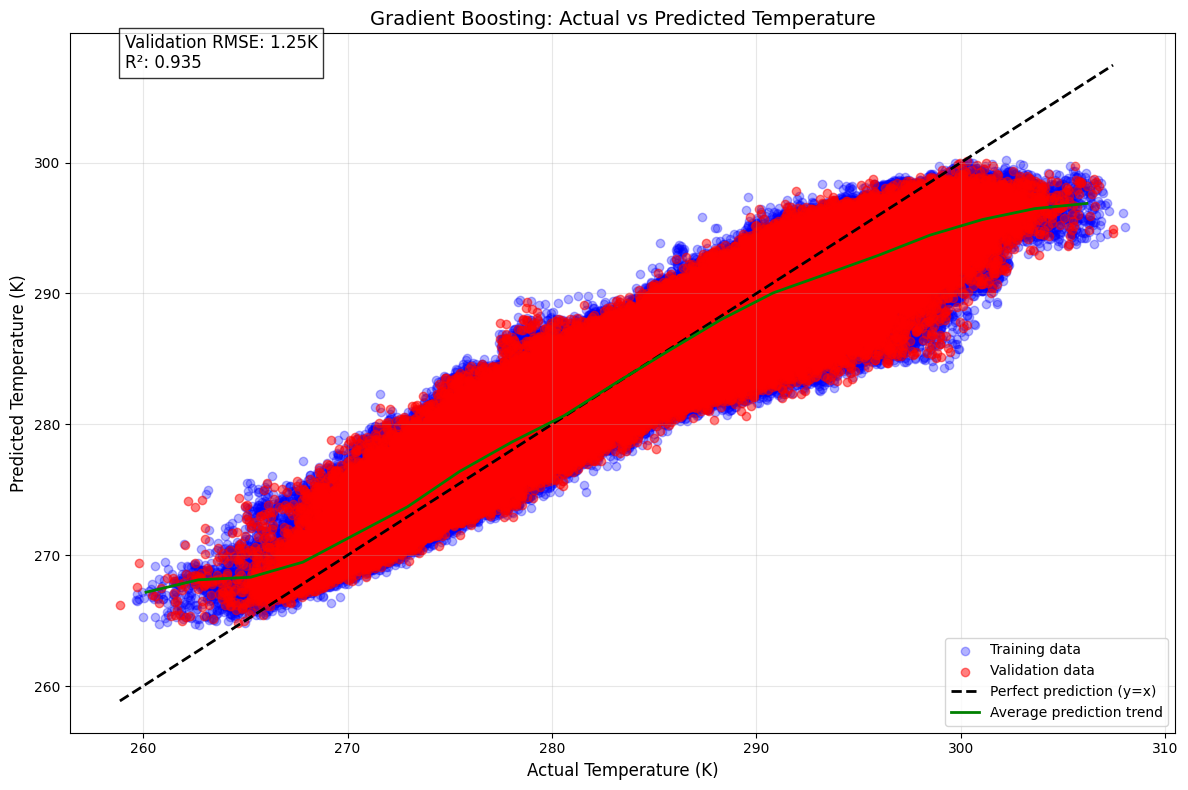

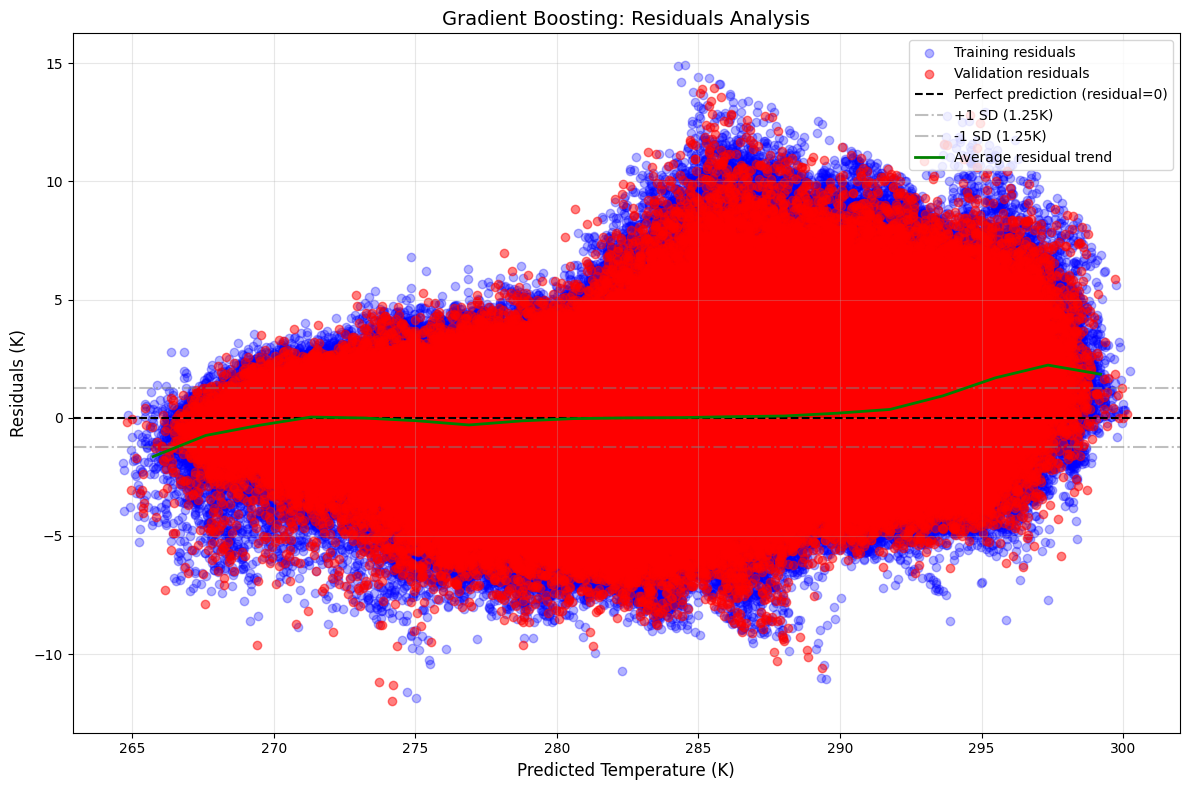

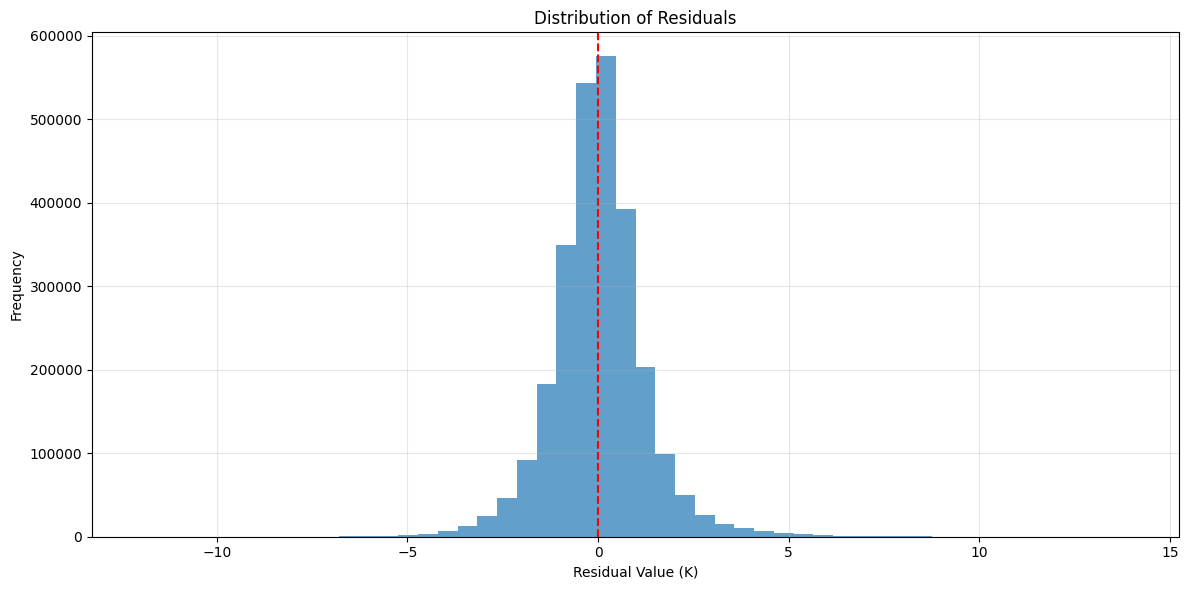

In [ ]:
# improved Actual vs Predicted plot
plt.figure(figsize=(12, 8))

# add separate colors for training and validation
plt.scatter(y_train, y_train_pred, alpha=0.3, label='Training data', color='blue')
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validation data', color='red')

# add perfect prediction line with label
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'k--', lw=2, label='Perfect prediction (y=x)')

# add a smoothed trend line to show actual model behavior
from scipy.stats import binned_statistic
bins = np.linspace(y_val.min(), y_val.max(), 20)
bin_means, bin_edges, _ = binned_statistic(y_val, y_val_pred, statistic='mean', bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average prediction trend')

# add metrics to the plot
plt.text(0.05, 0.95, f"Validation RMSE: {val_rmse:.2f}K\nR²: {val_r2:.3f}", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('Actual Temperature (K)', fontsize=12)
plt.ylabel('Predicted Temperature (K)', fontsize=12)
plt.title('Gradient Boosting: Actual vs Predicted Temperature', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# improved Residuals Plot
plt.figure(figsize=(12, 8))

# add separate colors for training and validation
plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.3, label='Training residuals', color='blue')
plt.scatter(y_val_pred, y_val - y_val_pred, alpha=0.5, label='Validation residuals', color='red')

# add zero line
plt.axhline(y=0, color='k', linestyle='--', label='Perfect prediction (residual=0)')

# add standard deviation bands
std_dev = np.std(y_val - y_val_pred)
plt.axhline(y=std_dev, color='gray', linestyle='-.', alpha=0.5, label=f'+1 SD ({std_dev:.2f}K)')
plt.axhline(y=-std_dev, color='gray', linestyle='-.', alpha=0.5, label=f'-1 SD ({std_dev:.2f}K)')

# add a smoothed trend line for residuals
bins = np.linspace(y_val_pred.min(), y_val_pred.max(), 20)
bin_means, bin_edges, _ = binned_statistic(y_val_pred, y_val - y_val_pred, statistic='mean', bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average residual trend')

# show residual analysis
plt.xlabel('Predicted Temperature (K)', fontsize=12)
plt.ylabel('Residuals (K)', fontsize=12)
plt.title('Gradient Boosting: Residuals Analysis', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residual Value (K)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.4 Feature Importance Analysis

This section shows the top 20 most important features for the model that was trained.

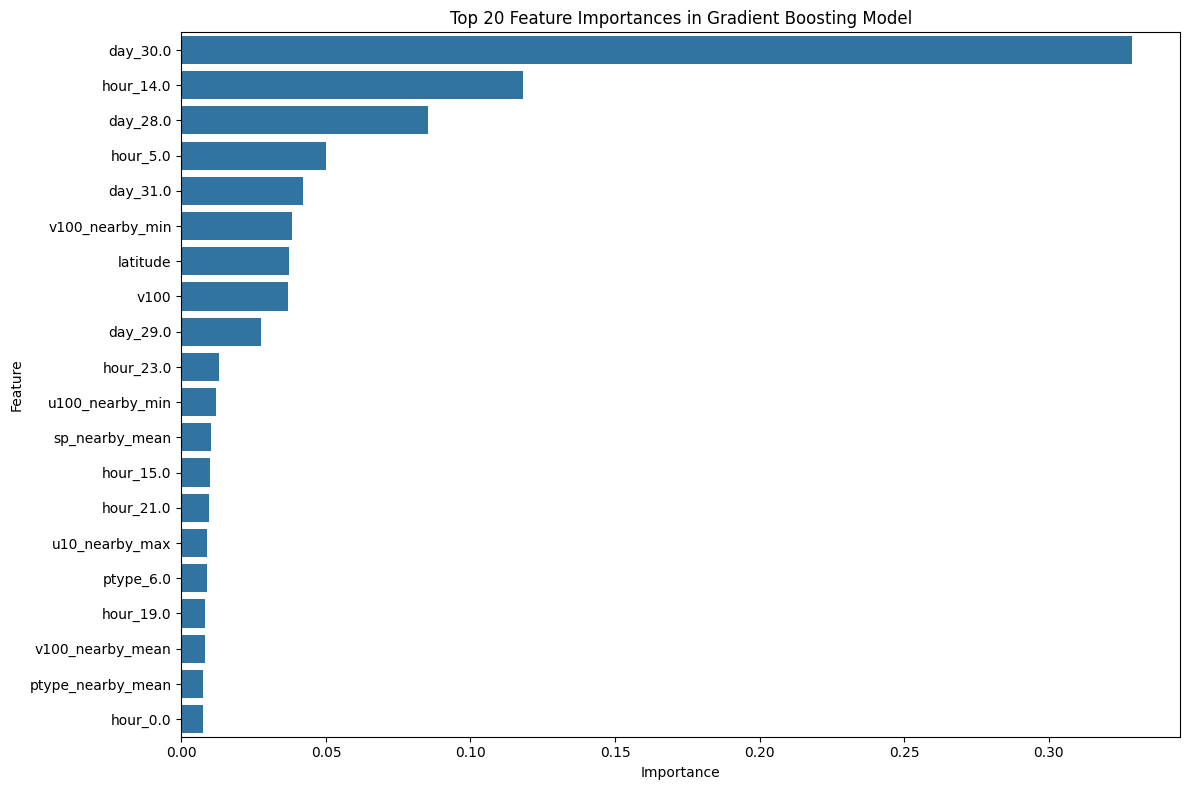

In [ ]:
# extract feature names after transformation
feature_names = []
cat_feature_names = []

# try to extract categorical feature names
try:
    cat_feature_names = list(gb_pipeline.named_steps['preprocessor']
                          .named_transformers_['cat-onehot']
                          .named_steps['onehot']
                          .get_feature_names_out(one_hot_attributes))
except:
    print("Warning: Could not extract categorical feature names - likely using older scikit-learn")
    # for older scikit-learn versions
    cat_feature_names = [f"{col}_{val}" for col in one_hot_attributes 
                       for val in range(10)]  # approximate feature names

feature_names = numerical_attributes + list(cat_feature_names)

# get feature importances
gb_model = gb_pipeline.named_steps['model']
feature_importances = gb_model.feature_importances_[:len(feature_names)]

# map importances to feature names
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_importances)],
    'Importance': feature_importances
})

# sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

# plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 Feature Importances in Gradient Boosting Model')
plt.tight_layout()
plt.show()

### 7. ADDITIONAL: Impact of Nearby Features

This section demonstrates the impact of incorporating nearby features by training identical XGBoost models on datasets with and without these new features. 

The comparative analysis quantifies how spatial information improves temperature prediction accuracy through direct RMSE and R² metric comparisons with visualisations showing performance differences. The results illustrate whether considering the geographical context of surrounding weather conditions significantly enhances prediction quality compared to using only local measurements.


--- Evaluating Impact of Nearby Features ---
Loaded datasets with nearby features from pickle files
Found 26 nearby feature columns
Dataset without nearby features shape: (13288920, 16)
Dataset with nearby features shape: (13288920, 42)
Created 10.0% samples for comparison
Sample with nearby features: (1328892, 42)
Sample without nearby features: (1328892, 16)

--- Training Models for Comparison (GPU-Accelerated) ---
Using XGBoost with GPU acceleration
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'tree_method': 'gpu_hist', 'gpu_id': 0}


c:\Users\Egor Ubiytsia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\Users\Egor Ubiytsia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Model with nearby features trained in 2.27 seconds


c:\Users\Egor Ubiytsia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Model without nearby features trained in 0.85 seconds


c:\Users\Egor Ubiytsia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Egor Ubiytsia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure th


--- Performance Comparison ---
RMSE with nearby features: 2.0295
RMSE without nearby features: 2.0677
Improvement with nearby features: 1.85%
R² with nearby features: 0.8281
R² without nearby features: 0.8216
R² improvement: 3.67% of remaining variance explained


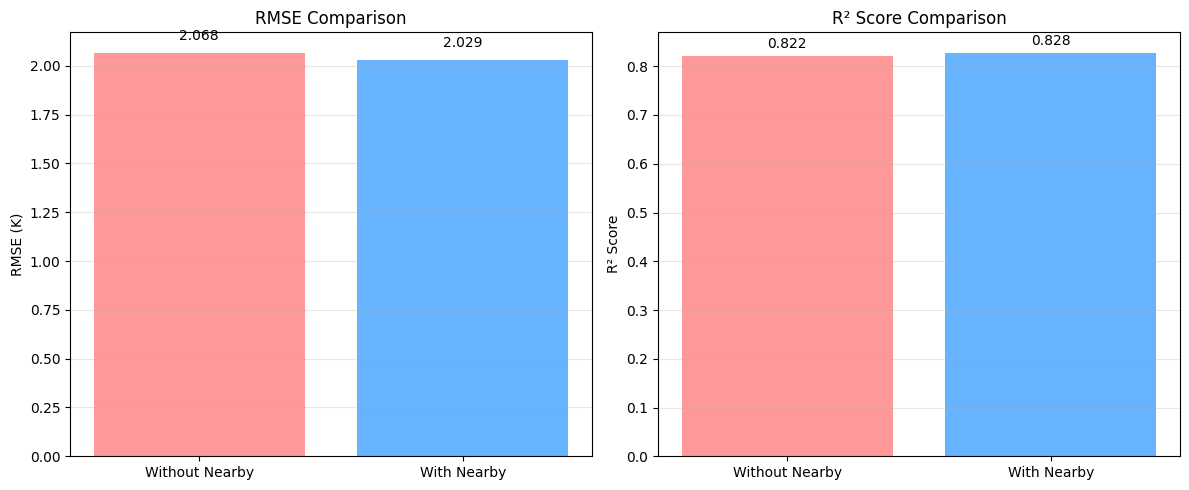

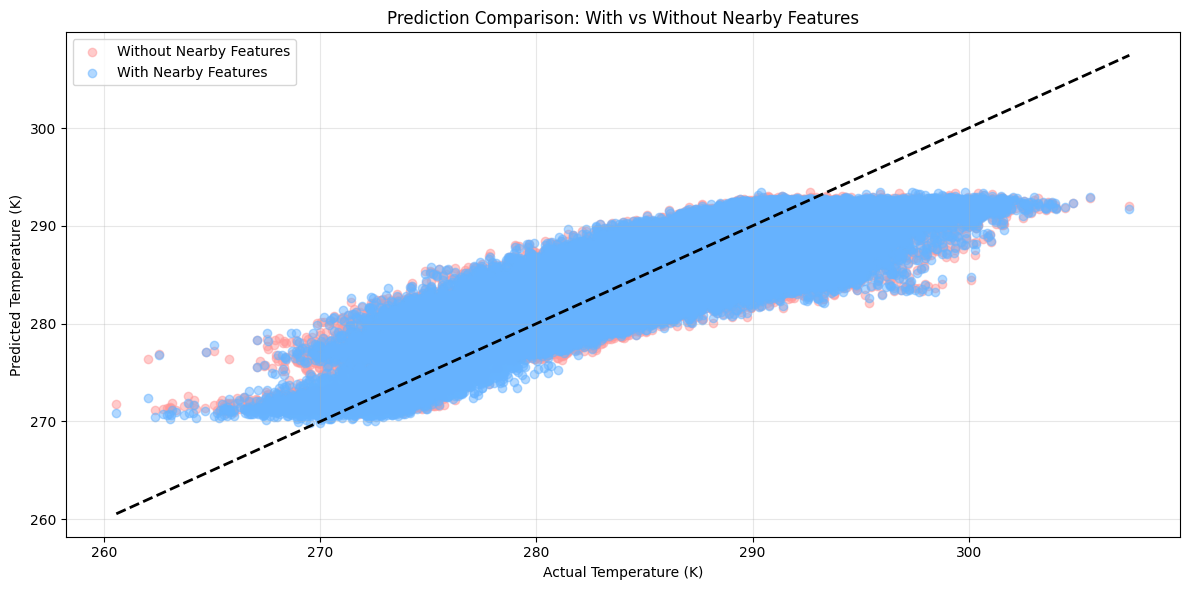

In [5]:
print("\n--- Evaluating Impact of Nearby Features ---")

# load dataset with nearby features
try:
    # load nearby-features datasets
    dataTrain_with_features = pd.read_pickle("./processed_datasets/train_with_features.pkl")
    print("Loaded datasets with nearby features from pickle files")
except:
    print("Using previously processed datasets with nearby features")
    # assume the datasets are already in memory from previous code execution

# create a dataset without nearby features by dropping those columns
nearby_columns = [col for col in dataTrain_with_features.columns 
                  if any(x in col for x in ['_nearby_', 'gradient'])]
print(f"Found {len(nearby_columns)} nearby feature columns")

# drop nearby features from the dataset
dataTrain_without_features = dataTrain_with_features.drop(columns=nearby_columns)
print(f"Dataset without nearby features shape: {dataTrain_without_features.shape}")
print(f"Dataset with nearby features shape: {dataTrain_with_features.shape}")

# create 10% samples for both datasets
sample_frac = 0.1
dataTrain_with_features_sample = dataTrain_with_features.sample(frac=sample_frac, random_state=RANDOM_SEED)
dataTrain_without_features_sample = dataTrain_without_features.loc[dataTrain_with_features_sample.index]

# check consistency of the samples
print(f"Created {sample_frac*100}% samples for comparison")
print(f"Sample with nearby features: {dataTrain_with_features_sample.shape}")
print(f"Sample without nearby features: {dataTrain_without_features_sample.shape}")

# prepare X and y for both samples
X_with_features = dataTrain_with_features_sample.drop("t2m", axis=1)
y_with_features = dataTrain_with_features_sample["t2m"]

X_without_features = dataTrain_without_features_sample.drop("t2m", axis=1)
y_without_features = dataTrain_without_features_sample["t2m"]

# split into training and validation sets
X_train_with, X_val_with, y_train_with, y_val_with = train_test_split(
    X_with_features, y_with_features, test_size=0.2, random_state=RANDOM_SEED)

X_train_without, X_val_without, y_train_without, y_val_without = train_test_split(
    X_without_features, y_without_features, test_size=0.2, random_state=RANDOM_SEED)

# define standard parameters for XGBoost (GPU-enabled)
standard_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,  # equivalent to max_features in GradientBoostingRegressor
    'random_state': RANDOM_SEED,
    'tree_method': 'gpu_hist',  # enable GPU acceleration
    'gpu_id': 0  # use first GPU (change if you have multiple GPUs)
}

# print training information
print("\n--- Training Models for Comparison (GPU-Accelerated) ---")
print("Using XGBoost with GPU acceleration")
print("Parameters:", standard_params)

# train model with nearby features
start_time = time.time()
model_with_features = xgb.XGBRegressor(**standard_params)
model_with_features.fit(X_train_with, y_train_with)
train_time_with = time.time() - start_time
print(f"Model with nearby features trained in {train_time_with:.2f} seconds")

# train model without nearby features
start_time = time.time()
model_without_features = xgb.XGBRegressor(**standard_params)
model_without_features.fit(X_train_without, y_train_without)
train_time_without = time.time() - start_time
print(f"Model without nearby features trained in {train_time_without:.2f} seconds")

# evaluate both models
y_pred_with = model_with_features.predict(X_val_with)
y_pred_without = model_without_features.predict(X_val_without)

rmse_with = np.sqrt(mean_squared_error(y_val_with, y_pred_with))
rmse_without = np.sqrt(mean_squared_error(y_val_without, y_pred_without))

r2_with = r2_score(y_val_with, y_pred_with)
r2_without = r2_score(y_val_without, y_pred_without)

# print performance comparison
print("\n--- Performance Comparison ---")
print(f"RMSE with nearby features: {rmse_with:.4f}")
print(f"RMSE without nearby features: {rmse_without:.4f}")
print(f"Improvement with nearby features: {100 * (rmse_without - rmse_with) / rmse_without:.2f}%")

print(f"R² with nearby features: {r2_with:.4f}")
print(f"R² without nearby features: {r2_without:.4f}")
print(f"R² improvement: {100 * (r2_with - r2_without) / (1 - r2_without):.2f}% of remaining variance explained")

# visualize performance comparison
plt.figure(figsize=(12, 5))

# RMSE comparison
plt.subplot(1, 2, 1)
bars = plt.bar(['Without Nearby', 'With Nearby'], [rmse_without, rmse_with], color=['#ff9999', '#66b3ff'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE (K)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.3f}', ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)

# R² comparison
plt.subplot(1, 2, 2)
bars = plt.bar(['Without Nearby', 'With Nearby'], [r2_without, r2_with], color=['#ff9999', '#66b3ff'])
plt.title('R² Score Comparison')
plt.ylabel('R² Score')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# scatter plot to compare predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_val_without, y_pred_without, alpha=0.5, label='Without Nearby Features', color='#ff9999')
plt.scatter(y_val_with, y_pred_with, alpha=0.5, label='With Nearby Features', color='#66b3ff')
plt.plot([y_val_with.min(), y_val_with.max()], [y_val_with.min(), y_val_with.max()], 'k--', lw=2)
plt.xlabel('Actual Temperature (K)')
plt.ylabel('Predicted Temperature (K)')
plt.title('Prediction Comparison: With vs Without Nearby Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()